In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler
import warnings
import neptune
# import networkx as nx


%load_ext autoreload
%autoreload 2

from src.features import *
from src.utils import *
from src.models import *
from src.optimizers import *
from src.loss_functions import *
from src.dataloaders import *
from src.security import NEPTUNE_TOKEN
from src.pipeline_functions import *

plt.style.use("ggplot")
# show all columns
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SEED = 45
set_seed(SEED)

In [3]:
stocks = ["SPY", "VTV", "VUG", "VYM", "QQQ", "VNQ", "GLD", "AGG", "SOXX", "OIH", "IYT", "XLF", "XLV", "VOX", "XLY", "XLP", "BND", "BSV", "IEMG", "VEA", "VWO"]
stocks = sorted(stocks)

stock_classes = {'AGG': 'EQUITY', 'GLD': 'COMMODITY', 'IYT': 'EQUITY', 'OIH': 'EQUITY', 'QQQ': 'EQUITY',
                 'SOXX': 'EQUITY', 'SPY': 'EQUITY', 'VNQ': 'REAL_ESTATE', 'VOX': 'EQUITY', 'VTV': 'EQUITY',
                 'VUG': 'EQUITY', 'VYM': 'EQUITY', 'XLF': 'EQUITY', 'XLP': 'EQUITY', 'XLV': 'EQUITY', 'XLY': 'EQUITY',
                 "BND": "FIXED_INCOME", "BSV": "FIXED_INCOME", "IEMG": "EQUITY", "VEA": "EQUITY", "VWO": "EQUITY"
}

classes_color = {'EQUITY': 'salmon', 'COMMODITY': 'cyan', 'FIXED_INCOME': 'lightgreen', "REAL_ESTATE": "lightblue"}

len(stocks)

21

In [4]:
path = "C:\\Users\\Андрей\\Documents\\diploma_python\\data"

df_adj_close, df_close, df_high, df_low, df_volume = get_data(path, stocks)

AGG Start of history: 2003-09-29
BND Start of history: 2007-04-10
BSV Start of history: 2007-04-10
GLD Start of history: 2004-11-18
IEMG Start of history: 2012-10-24
IYT Start of history: 2004-01-02
OIH Start of history: 2001-02-26
QQQ Start of history: 1999-03-10
SOXX Start of history: 2001-07-13
SPY Start of history: 1993-01-29
VEA Start of history: 2007-07-26
VNQ Start of history: 2004-09-29
VOX Start of history: 2004-09-29
VTV Start of history: 2004-01-30
VUG Start of history: 2004-01-30
VWO Start of history: 2005-03-10
VYM Start of history: 2006-11-16
XLF Start of history: 1998-12-22
XLP Start of history: 1998-12-22
XLV Start of history: 1998-12-22
XLY Start of history: 1998-12-22


In [5]:
nodes_matrix, combined_adj_matrix, cov_adj_matrix, future_return, df_return, df_features = features_pipeline(df_adj_close, df_close, df_high, df_low, df_volume, stocks=stocks)

Features generated and scaled
Return features generated
Correlation and covariance matrices generated
Common index length 2416


100%|██████████| 2416/2416 [05:21<00:00,  7.51it/s]

Adjacency matrices generated
Pipeline finished


In [6]:
TRAIN = 1800
PERIOD = 90 #max window for features' calculation

train_dataset = Dataset(nodes_matrix[:TRAIN], 
                          combined_adj_matrix[:TRAIN], 
                          cov_adj_matrix[:TRAIN], 
                          future_return[:TRAIN])

test_dataset = Dataset(nodes_matrix[TRAIN+PERIOD:],
                            combined_adj_matrix[TRAIN+PERIOD:],
                            cov_adj_matrix[TRAIN+PERIOD:],
                            future_return[TRAIN+PERIOD:])

len(test_dataset)

526

In [17]:
model_dic = {}

for i in range(10):

  model = GrossModel(num_features=23, num_relations=5, num_assets=21, sample_size=10, pred_window=5, n_heads=2, train_gamma=False, gamma=0.01+0.005*i)
  optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

  loss_list, gamma_list = train(model, optim, train_dataset, epochs=4,
                            eval_func='sharpe_loss', exp_name=f'exp_2405_gamma_v{i+1}', neptune_token=NEPTUNE_TOKEN,
                              neptune_project="aibabynin/graphs", tags=["gamma_training"])
  
  model_dic[i] = {"model": model,
                  "optimizer": optim, 
                  "loss_list": loss_list, 
                  "gamma_list": gamma_list}

  print(f"{i+1} is trained")


https://app.neptune.ai/aibabynin/graphs/e/GRAP-15
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-15/metadata
1 is trained
https://app.neptune.ai/aibabynin/graphs/e/GRAP-16
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
All 6 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-16/metadata
2 is trained
https://app.neptune.ai/aibabynin/graphs/e/GRAP-17
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in 

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterConnectionError
Communication with Neptune restored!


In [19]:
for i in range(10):
    test_weights_matrix = evaluate(model_dic[i]['model'], test_dataset)
    model_dic[i]['test_weights_matrix'] = test_weights_matrix
    
    print(f"{i+1} is evaluated")

100%|██████████| 511/511 [00:19<00:00, 25.77it/s]


1 is evaluated


100%|██████████| 511/511 [00:22<00:00, 22.43it/s]


2 is evaluated


100%|██████████| 511/511 [00:22<00:00, 22.24it/s]


3 is evaluated


100%|██████████| 511/511 [00:23<00:00, 22.01it/s]


4 is evaluated


100%|██████████| 511/511 [00:23<00:00, 21.80it/s]


5 is evaluated


100%|██████████| 511/511 [00:23<00:00, 22.15it/s]


6 is evaluated


100%|██████████| 511/511 [00:23<00:00, 22.19it/s]


7 is evaluated


100%|██████████| 511/511 [00:23<00:00, 21.82it/s]


8 is evaluated


100%|██████████| 511/511 [00:23<00:00, 21.94it/s]


9 is evaluated


100%|██████████| 511/511 [00:24<00:00, 20.66it/s]

10 is evaluated


In [20]:
ret = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].values
index = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].index

In [24]:
returns_matrix = np.zeros((10, len(ret)))

for i in range(10):

    returns_matrix[i] = (ret * model_dic[i]['test_weights_matrix']).sum(1)


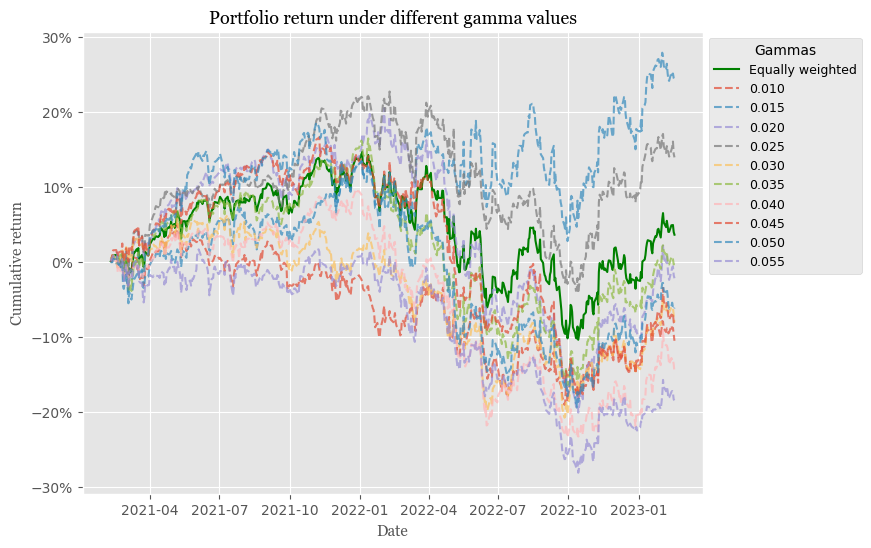

In [72]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
_ = plt.plot(index, (ret.mean(1)+1).cumprod()- 1, color='green', label='Equally weighted')

for i in range(10):
    _ = plt.plot(index, (returns_matrix[i]+1).cumprod()- 1, label=f'{0.01+0.005*i:.3f}', alpha=0.7, linestyle='--')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Date', fontsize=11, fontname='Georgia')
plt.ylabel('Cumulative return', fontsize=11, fontname='Georgia')
plt.title('Portfolio return under different gamma values', fontsize=13, fontname='Georgia')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Gammas', fontsize=9)
plt.show()

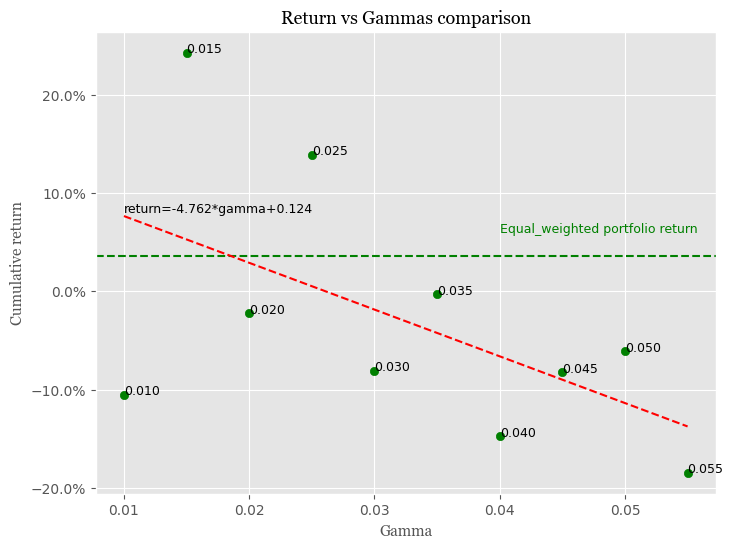

In [73]:
#draw scatter plot of gamma values and cumulative portfolio return
plt.figure(figsize=(8, 6))

for i in range(10):
    _ = plt.scatter(0.01+0.005*i, ((returns_matrix[i]+1).cumprod()- 1)[-1], color='green')
    #add labels to points
    _ = plt.annotate(f'{0.01+0.005*i:.3f}', (0.01+0.005*i, ((returns_matrix[i]+1).cumprod()- 1)[-1]), fontsize=9)

#add linear regression line 
x = np.array([0.01+0.005*i for i in range(10)])
#draw horizontal line with equal weight portfolio
_ = plt.axhline(((ret.mean(1)+1).cumprod()- 1)[-1], color='green', linestyle='--')
_ = plt.annotate(f'Equal_weighted portfolio return', (0.04, 0.06), fontsize=9, color='green')

y = np.array([((returns_matrix[i]+1).cumprod()- 1)[-1] for i in range(10)])
m, b = np.polyfit(x, y, 1)
_ = plt.plot(x, m*x + b, color='red', linestyle='--')
#add labels to linear regression line (bold font)
_ = plt.annotate(f'return={m:.3f}*gamma+{b:.3f}', (0.01, 0.08), fontsize=9)

plt.xlabel('Gamma', fontsize=11, fontname='Georgia')
#change y scale to %
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#define mtick

plt.ylabel('Cumulative return', fontsize=11, fontname='Georgia')
plt.title('Return vs Gammas comparison', fontsize=13, fontname='Georgia')
plt.show()


In [74]:
#torch save model locally
for i in range(10):
    torch.save(model_dic[i]['model'].state_dict(), f"model_gamma_{0.01+0.005*i:.3f}.pt")
    print(f"{i+1} model saved")

1 model saved
2 model saved
3 model saved
4 model saved
5 model saved
6 model saved
7 model saved
8 model saved
9 model saved
10 model saved
